ЛАБОРАТОРНАЯ РАБОТА №6. «ОБУЧЕНИЕ БЕЗ УЧИТЕЛЯ. ЗАДАЧА КЛАСТЕРИЗАЦИИ»

ЗАДАНИЕ №1
1. Сгенерировать 3 датасета (make_classification или make_blobs)
2. Провести визуализацию
3. Провести кластеризацию (все методы)
4. Для каждого метода подобрать оптимальные гиперпараметры.
5. Самостоятельно реализовать KMeans. Проверить его работу на датасетах.
6. Каждый метод оценивать 2 внешними и 2 внутренними метриками.

ЗАДАНИЕ №2.  
1. На основе датасета для задачи классификации построить модель кластеризации, используя три метода: k-means; иерархическая кластеризация; DBSCAN.
2. Произвести визуализацию построенных моделей.
3. Выполнить оценку качества полученных моделей кластеризации. Сравнить полученные результаты.


ЗАДАНИЕ №3*.
Реализовать алгоритма DBSCAN и с его помощью провести кластеризацию всех датасетов Лаб_работы №6.

In [2]:
from sklearn.datasets import make_classification
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, rand_score, make_scorer, calinski_harabasz_score
import pandas as pd
from scipy.stats import zscore
from pprint import pprint

# Функции:

In [3]:
def elbow_method(data, num_clusters_range=10):
    '''
    "data" - Датасет
    "num_clusters_range" - количество итераций. По умолчанию 10

    '''
    scores = []

    for iteration in range(1, num_clusters_range + 1):
        model = KMeans(n_clusters=iteration, n_init='auto').fit(data)
        scores.append(model.inertia_)

    return scores


In [4]:
def plot_schedule(data, model, title):
    '''
    "data" - Датасет
    "model" - Обученная модель кластеризации
    "title" - Название графика

    '''
    plt.scatter(data[:, 0], data[:, 1], c = model.labels_)
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=70, c='red')
    plt.title(title)
    plt.show()


In [5]:
def get_metrics(data, y, model) -> dict:
    '''
    Получает метрики для оценки качества кластеризации.

    Параметры:
        - data: Данные для кластеризации.
        - y: Истинные метки кластеров.
        - model: Обученная модель кластеризации.

    Возвращает:
        Словарь с метриками, включая silhouette_score, rand_score, adjusted_rand_score, normalized_mutual_info_score.
    '''
    try:
      y_pred = model.labels_
    except:
      y_pred = model.predict(data)

    metrics = {
        'silhouette_score': round(silhouette_score(data, y_pred), 2),
        'calinski_harabasz_score': round(calinski_harabasz_score(data, y_pred),2),
        'rand_score' : round(rand_score(y_pred, y), 2),
        'adjusted_rand_score' : round(adjusted_rand_score(y, y_pred), 2),
    }

    return metrics

In [6]:
def print_metrics(title, model1, model2, model3):
    dict_dataset_metrics = dict()
    for index, (X, y, model) in enumerate([(X_one, y_one, model1), (X_two, y_two, model2), (X_three, y_three, model3)]):
        metrics = get_metrics(X, y, model)
        dict_dataset_metrics['{} {}'.format(title,index+1)] = metrics
    pprint(dict_dataset_metrics)

In [7]:
X_one, y_one = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
X_two, y_two = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=66)
X_three, y_three = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=99)

In [8]:
z_scores = zscore(X_two)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2.5).all(axis=1)
X_two = X_two[filtered_entries]
y_two = y_two[filtered_entries]

In [9]:
z_scores = zscore(X_three)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
X_three = X_three[filtered_entries]
y_three = y_three[filtered_entries]

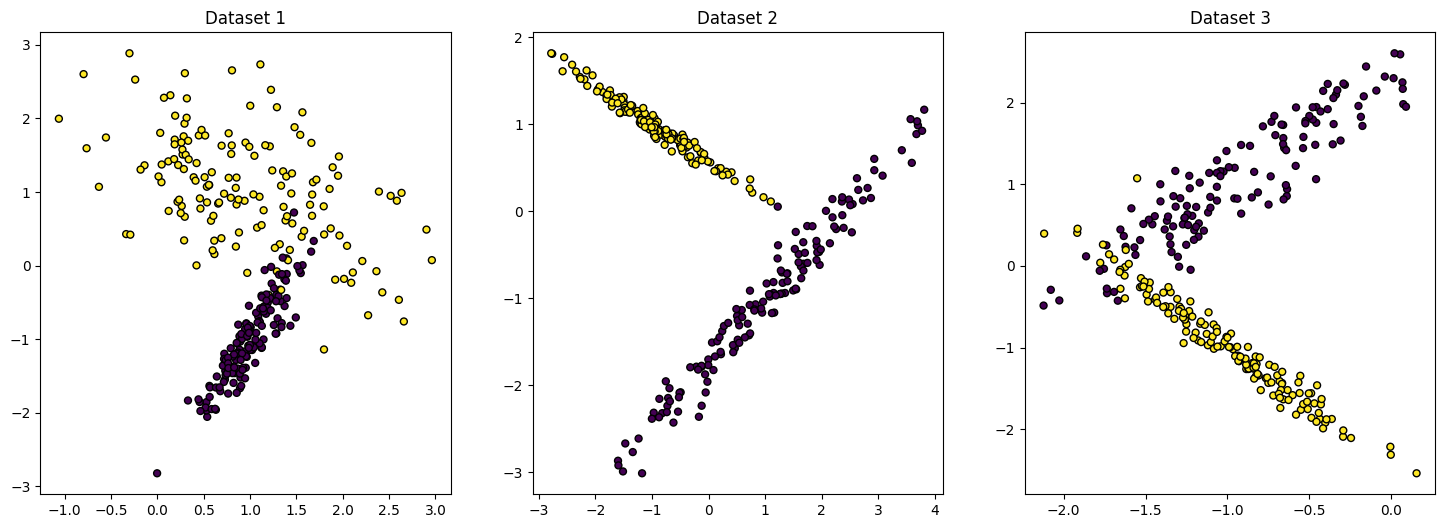

In [10]:
plt.figure(figsize=(18, 6))
for index, (data, y) in enumerate([(X_one, y_one), (X_two, y_two), (X_three, y_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], marker="o", c=y, s=25, edgecolor="k")
    plt.title(f"Dataset {index+1}")
plt.show()

#  Методы кластеризации

## KMeans - без подобра числа кластеров

In [11]:
kmeans_dataset_one = KMeans(n_init='auto').fit(X_one)
kmeans_dataset_two = KMeans(n_init='auto').fit(X_two)
kmeans_dataset_three = KMeans(n_init='auto').fit(X_three)

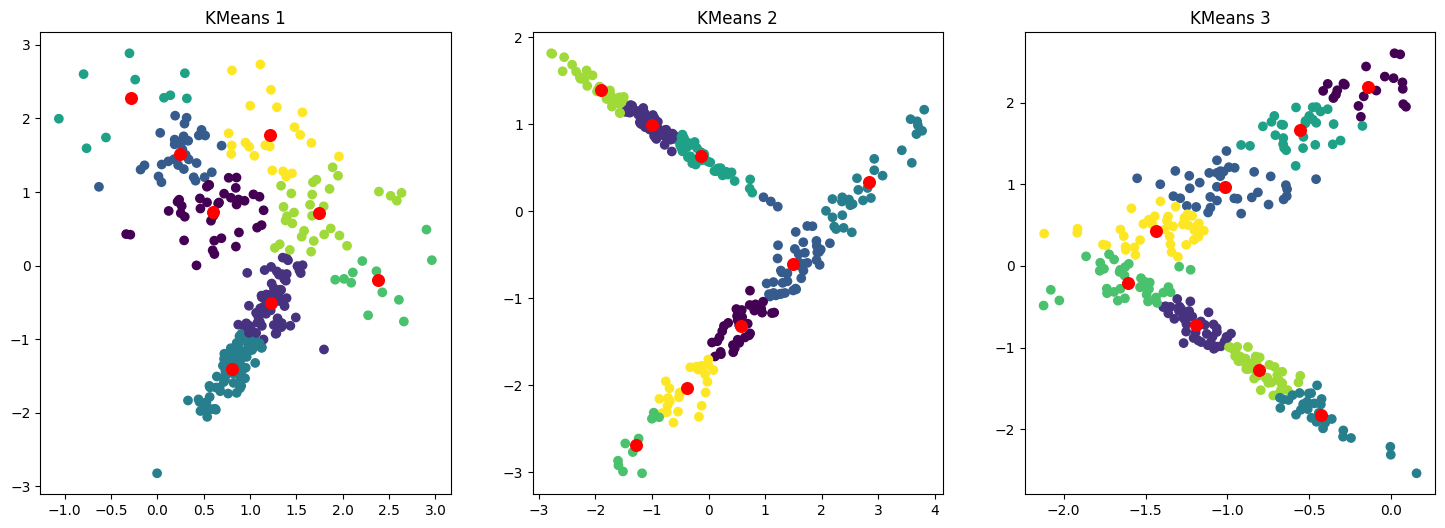

In [12]:
plt.figure(figsize=(18, 6))
for index, files in enumerate([(X_one, kmeans_dataset_one), (X_two,kmeans_dataset_two), (X_three, kmeans_dataset_three)]):
    data = files[0]
    model = files[1]
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.labels_)
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=70, c='red')
    plt.title(f"KMeans {index+1}")
plt.show()

### Основные метрики

1. **Скорректированный индекс Рэнда (Adjusted Rand Score):** Измеряет схожесть между фактическими и предсказанными кластеризациями. Значения ближе к 1 указывают на лучшее соответствие.

2. **Балл Калински и Харабаша. (calinski_harabasz_score):** Это тоже внутренняя метрика, которая оценивает качество кластеризации, основываясь на отношении внутрикластерного разброса к межкластерному разбросу. Чем выше индекс, тем лучше кластеризация.

3. **Индекс Рэнда (Rand Score):** Показывает схожесть между фактическими и предсказанными кластеризациями, где 1 - идеальное соответствие. Учитывает истинно положительные и истинно отрицательные значения.

4. **Коэффициент силуэта (Silhouette Score):** Измеряет, насколько объект похож на свой собственный кластер по сравнению с другими кластерами. Имеет значения от -1 до 1, где более высокие значения указывают на лучшую дифференциацию кластеров.


### Продолжение

In [13]:
print_metrics("KMeans", kmeans_dataset_one, kmeans_dataset_two, kmeans_dataset_three)

{'KMeans 1': {'adjusted_rand_score': 0.31,
              'calinski_harabasz_score': 400.82,
              'rand_score': 0.66,
              'silhouette_score': 0.43},
 'KMeans 2': {'adjusted_rand_score': 0.28,
              'calinski_harabasz_score': 807.24,
              'rand_score': 0.64,
              'silhouette_score': 0.49},
 'KMeans 3': {'adjusted_rand_score': 0.2,
              'calinski_harabasz_score': 998.59,
              'rand_score': 0.6,
              'silhouette_score': 0.44}}


## KMeans - с подбором числа кластеров

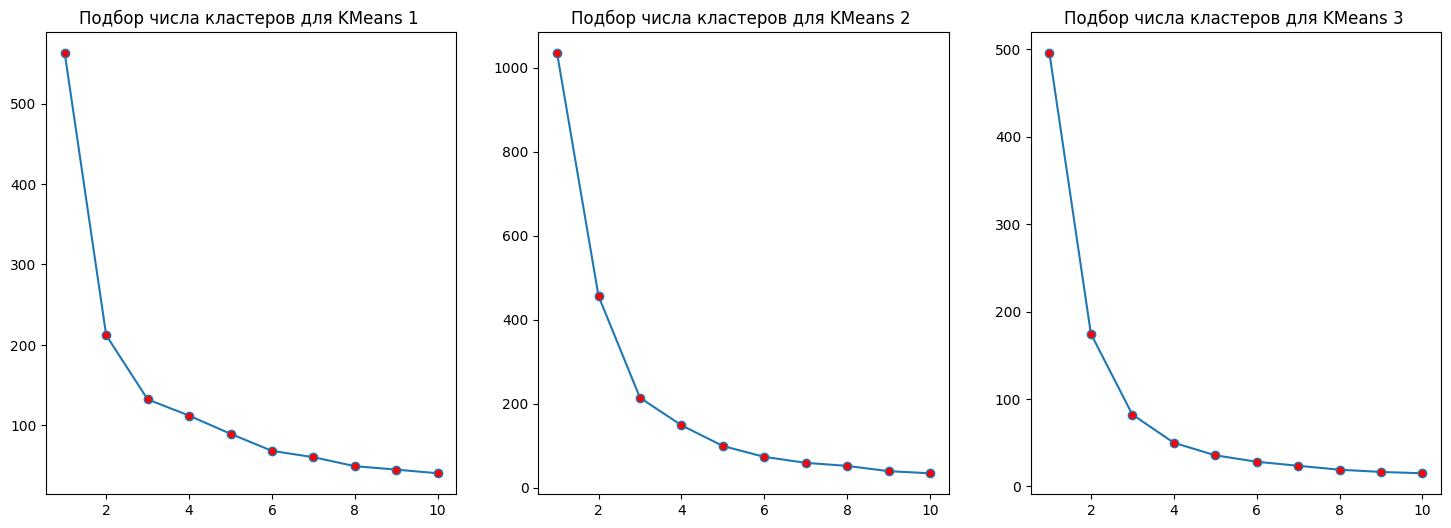

In [14]:
iterations = 10
plt.figure(figsize=(18, 6))
for index, data in enumerate([X_one, X_two, X_three]):
    results_iter = elbow_method(data, iterations)
    plt.subplot(1, 3, index+1)
    plt.plot(range(1, iterations+1), results_iter, marker='o', markerfacecolor=[1, 0, 0, 1])
    plt.title("Подбор числа кластеров для KMeans {} ".format(index+1))
plt.show()

In [15]:
kmeans_dataset_one = KMeans(n_clusters = 3, n_init='auto').fit(X_one)
kmeans_dataset_two = KMeans(n_clusters = 3, n_init='auto').fit(X_two)
kmeans_dataset_three = KMeans(n_clusters = 4, n_init='auto').fit(X_three)

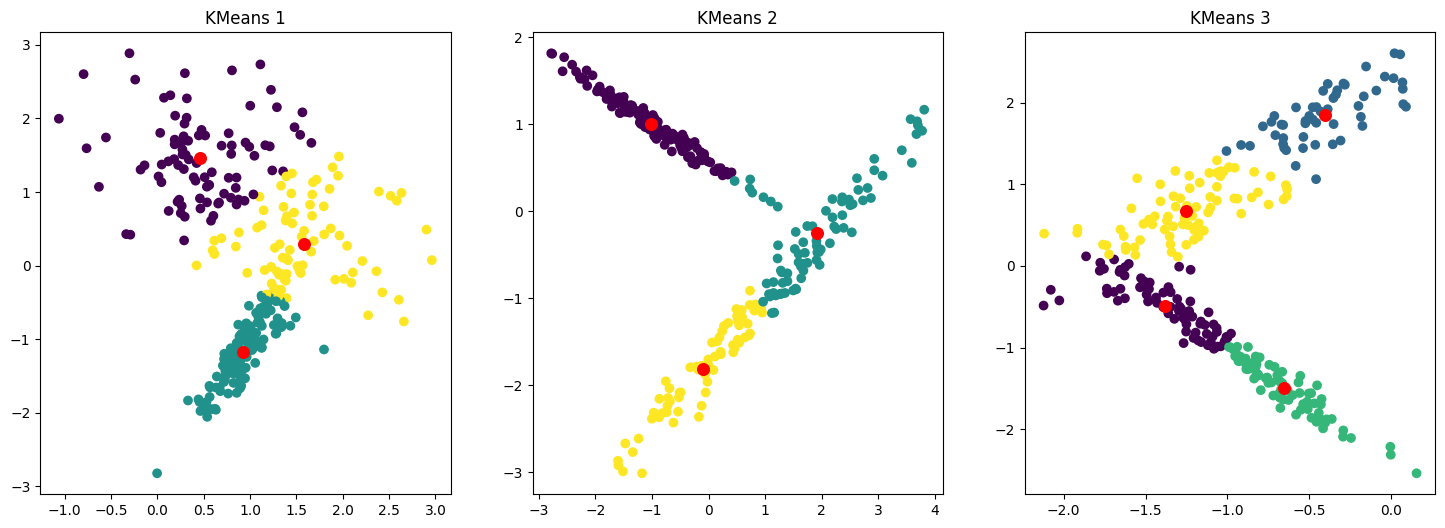

In [16]:
plt.figure(figsize=(18, 6))
for index, (data, model) in enumerate([(X_one, kmeans_dataset_one), (X_two,kmeans_dataset_two), (X_three, kmeans_dataset_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.labels_)
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=70, c='red')
    plt.title(f"KMeans {index+1}")
plt.show()

In [17]:
print_metrics("KMeans", kmeans_dataset_one, kmeans_dataset_two, kmeans_dataset_three)

{'KMeans 1': {'adjusted_rand_score': 0.55,
              'calinski_harabasz_score': 482.12,
              'rand_score': 0.78,
              'silhouette_score': 0.49},
 'KMeans 2': {'adjusted_rand_score': 0.68,
              'calinski_harabasz_score': 556.55,
              'rand_score': 0.84,
              'silhouette_score': 0.62},
 'KMeans 3': {'adjusted_rand_score': 0.38,
              'calinski_harabasz_score': 830.89,
              'rand_score': 0.69,
              'silhouette_score': 0.53}}


## DBSCAN - без подбора гиперпараметров

In [18]:
dbscan_one = DBSCAN().fit(X_one)
dbscan_two = DBSCAN().fit(X_two)
dbscan_three = DBSCAN().fit(X_three)

In [19]:
print("Количество уникальных labels для Dataset_one {}".format(len(np.unique(dbscan_one.labels_))))
print("Количество уникальных labels для Dataset_two {}".format(len(np.unique(dbscan_two.labels_))))
print("Количество уникальных labels для Dataset_three {}".format(len(np.unique(dbscan_three.labels_))))

Количество уникальных labels для Dataset_one 2
Количество уникальных labels для Dataset_two 1
Количество уникальных labels для Dataset_three 1


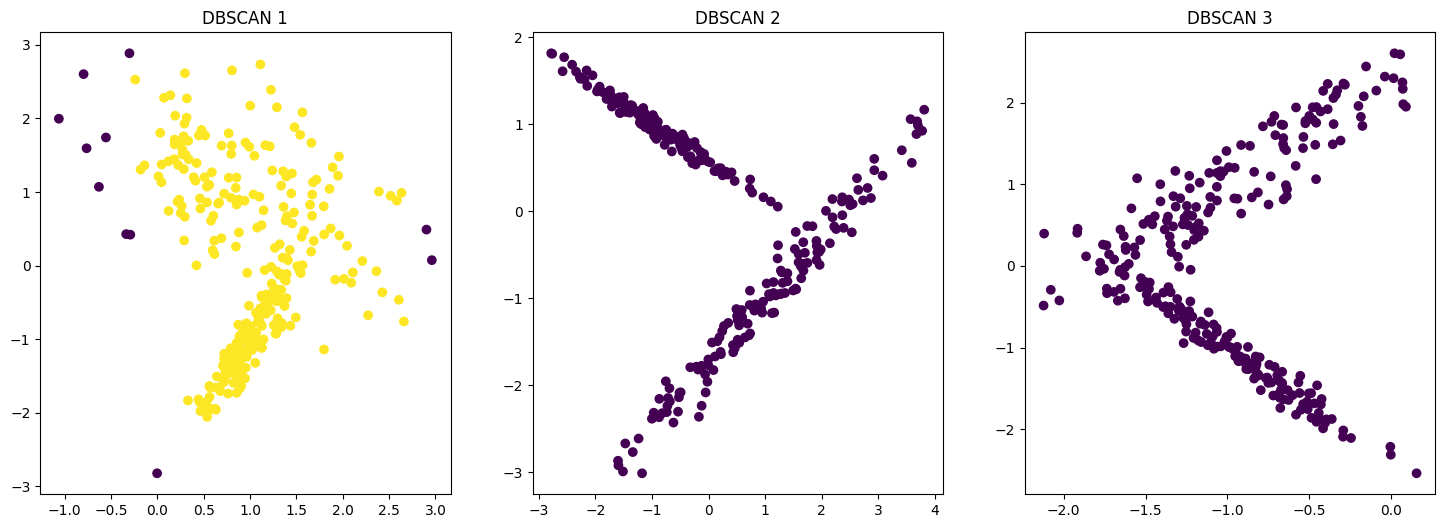

In [20]:
plt.figure(figsize=(18, 6))
for index, (data, model) in enumerate([(X_one, dbscan_one), (X_two,dbscan_two), (X_three, dbscan_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.labels_)
    plt.title(f"DBSCAN {index+1}")
plt.show()

## DBSCAN - с подбором гиперпараметров

In [21]:
eps_values = [0.1, 0.5, 1.0, 1.5]
min_samples_values = [3, 5, 10, 15]
best_params = dict()

for index, (X, y) in enumerate([(X_one, y_one), (X_two, y_two), (X_three, y_three)]):
    best_score = -1
    temporary_dict = dict()

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            rand = rand_score(y, dbscan.labels_)

            if rand > best_score:
                best_score = rand
                temporary_dict = {"eps": eps, 'min_samples': min_samples, 'best_rand': rand}

    best_params[f'DBSCAN {index+1}'] = temporary_dict


In [22]:
best_params

{'DBSCAN 1': {'eps': 0.1, 'min_samples': 5, 'best_rand': 0.7474470457079153},
 'DBSCAN 2': {'eps': 0.5, 'min_samples': 10, 'best_rand': 0.9677404273224555},
 'DBSCAN 3': {'eps': 0.1, 'min_samples': 3, 'best_rand': 0.7160865097862316}}

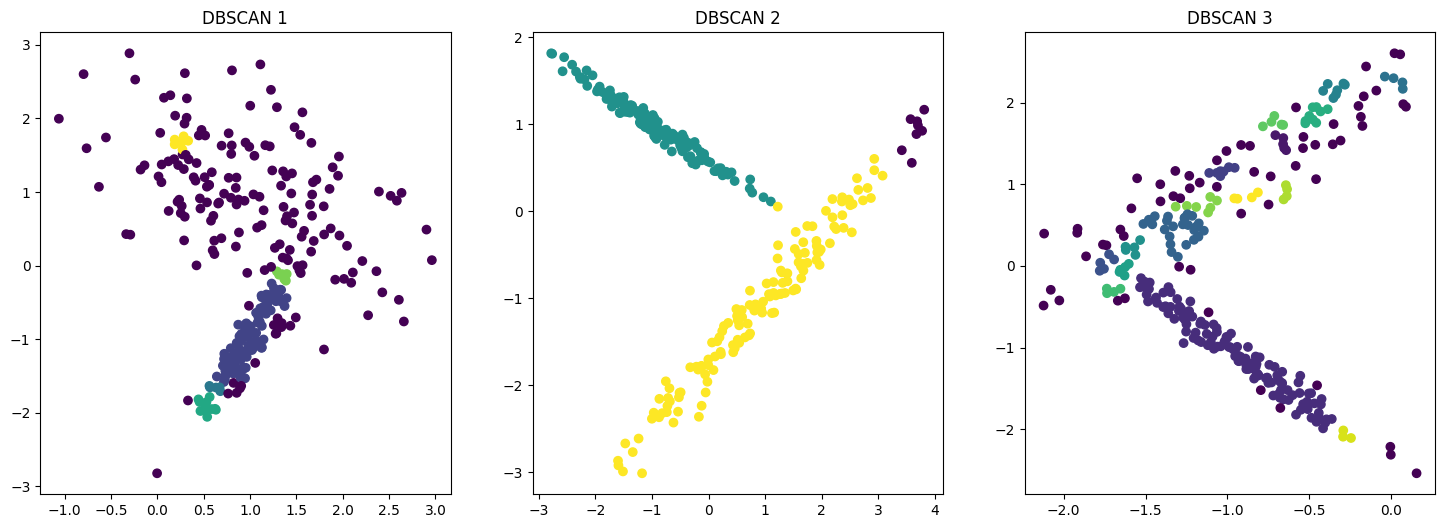

In [23]:
dbscan_one = DBSCAN(eps=0.1, min_samples=5).fit(X_one)
dbscan_two = DBSCAN(eps=0.5, min_samples=10).fit(X_two)
dbscan_three = DBSCAN(eps=0.1, min_samples=3).fit(X_three)

plt.figure(figsize=(18, 6))

for index, (data, model) in enumerate([(X_one, dbscan_one), (X_two, dbscan_two), (X_three, dbscan_three)]):
    plt.subplot(1, 3, index + 1)
    plt.scatter(data[:, 0], data[:, 1], c=model.labels_)
    plt.title(f"DBSCAN {index+1}")

plt.show()

In [24]:

print_metrics("DBSCAN", dbscan_one, dbscan_two, dbscan_three)

{'DBSCAN 1': {'adjusted_rand_score': 0.49,
              'calinski_harabasz_score': 56.07,
              'rand_score': 0.75,
              'silhouette_score': -0.19},
 'DBSCAN 2': {'adjusted_rand_score': 0.94,
              'calinski_harabasz_score': 251.57,
              'rand_score': 0.97,
              'silhouette_score': 0.53},
 'DBSCAN 3': {'adjusted_rand_score': 0.43,
              'calinski_harabasz_score': 36.82,
              'rand_score': 0.72,
              'silhouette_score': -0.02}}


Удалить аномалии

## GaussianMixture (Гауссова смесь распределений) - без подобра числа кластеров

In [25]:
gm_one = GaussianMixture(n_components=2, random_state=17).fit(X_one)
gm_two = GaussianMixture(n_components=2, random_state=17).fit(X_two)
gm_three = GaussianMixture(n_components=2, random_state=17).fit(X_three)

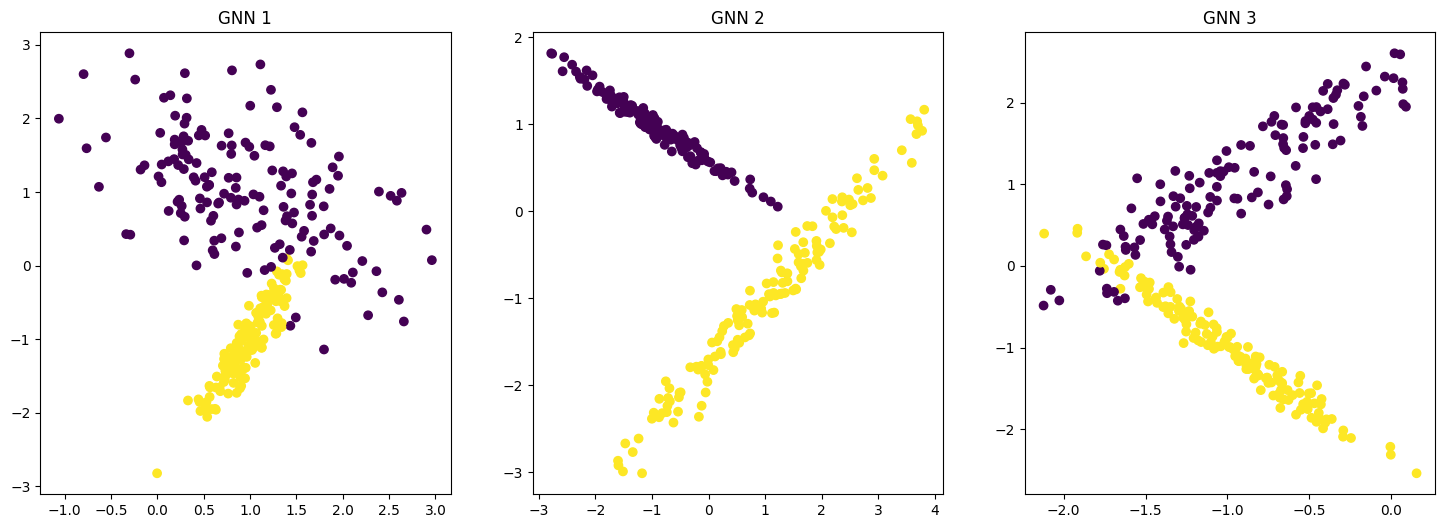

In [26]:

plt.figure(figsize=(18, 6))
for index, (data, model) in enumerate([(X_one, gm_one), (X_two, gm_two), (X_three, gm_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.predict(data))
    plt.title(f"GNN {index+1}")
plt.show()

In [27]:
print_metrics("GaussianMixture", gm_one, gm_two, gm_three)

{'GaussianMixture 1': {'adjusted_rand_score': 0.83,
                       'calinski_harabasz_score': 388.09,
                       'rand_score': 0.92,
                       'silhouette_score': 0.5},
 'GaussianMixture 2': {'adjusted_rand_score': 0.97,
                       'calinski_harabasz_score': 345.21,
                       'rand_score': 0.99,
                       'silhouette_score': 0.56},
 'GaussianMixture 3': {'adjusted_rand_score': 0.92,
                       'calinski_harabasz_score': 430.63,
                       'rand_score': 0.96,
                       'silhouette_score': 0.51}}


## GaussianMixture (Гауссова смесь распределений)- подбор числа кластеров

In [28]:
n_iterations = 10
dict_aic = dict()
for index, data in enumerate([X_one, X_two, X_three]):
    scores = []
    best_aic = np.inf

    for iter in range(1, n_iterations+1):
        model = GaussianMixture(n_components=iter, random_state=17).fit(data)
        aic = model.aic(data)
        scores.append(aic)
        if aic < best_aic:
            best_aic = aic

    dict_aic[f'Model {index+1}'] = scores

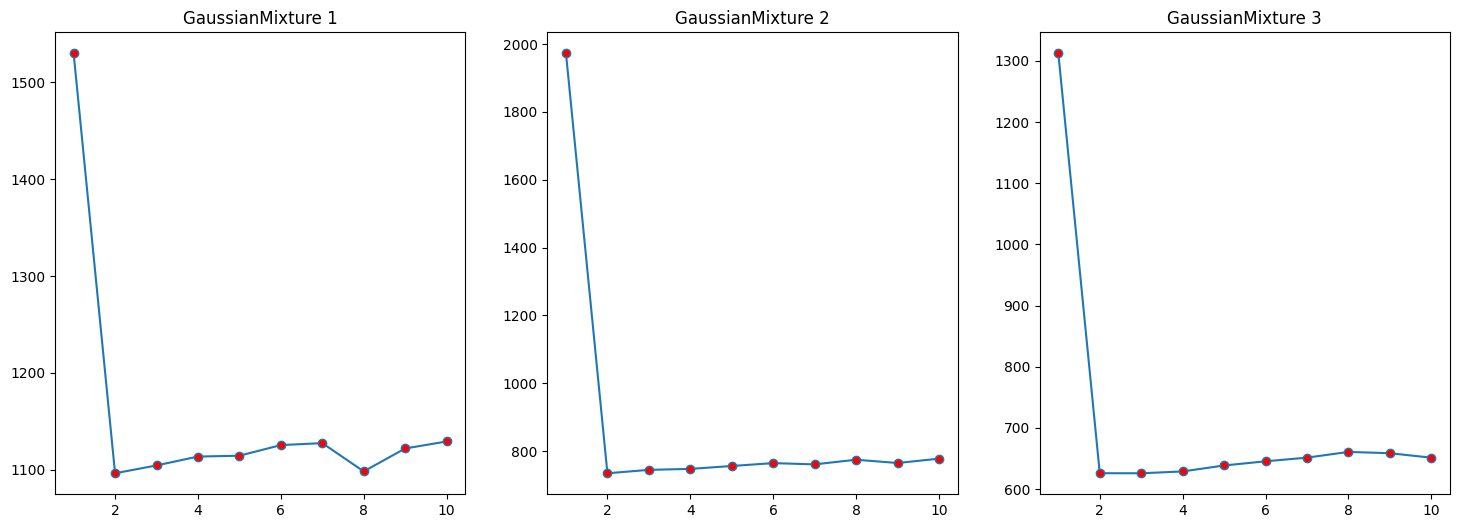

In [29]:
iterations = 10
plt.figure(figsize=(18, 6))
for index, data in enumerate([dict_aic['Model 1'], dict_aic['Model 2'], dict_aic['Model 3']]):
    plt.subplot(1, 3, index+1)
    plt.plot(range(1, iterations+1), data, marker='o', markerfacecolor=[1, 0, 0, 1])
    plt.title("GaussianMixture {}".format(index+1))
plt.show()

Такой же результат как и без подбора

## AgglomerativeClustering - без подбора числа кластеров

In [30]:
ac_model_one  = AgglomerativeClustering().fit(X_one)
ac_model_two  = AgglomerativeClustering().fit(X_two)
ac_model_three  = AgglomerativeClustering().fit(X_three)

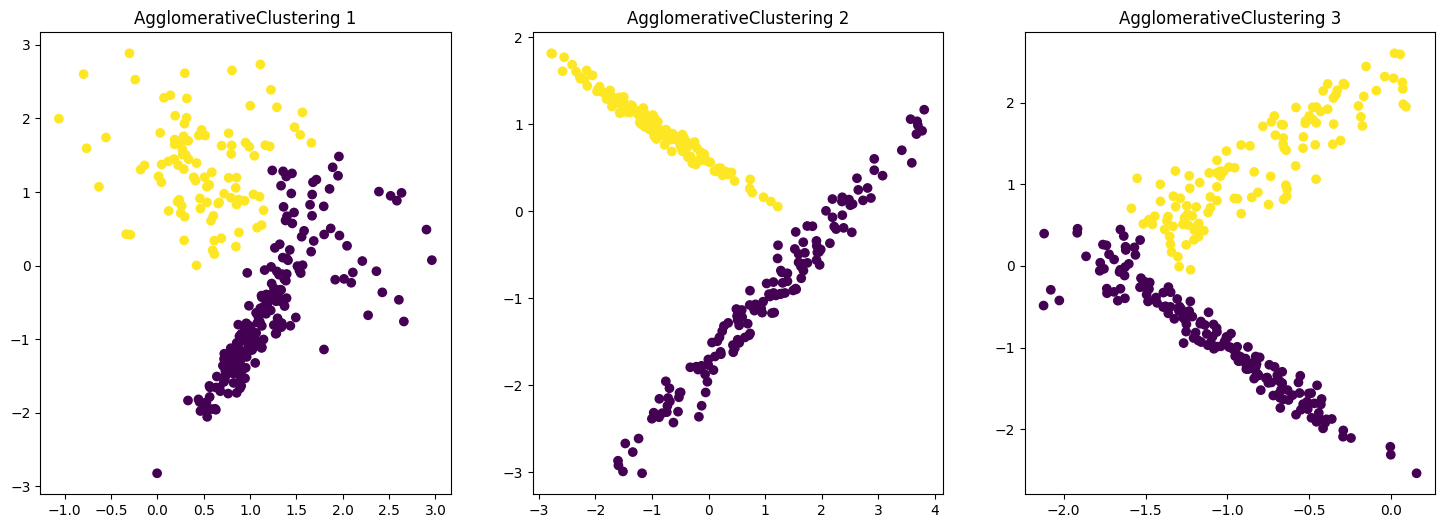

In [31]:
plt.figure(figsize=(18, 6))
for index, (data, model) in enumerate([(X_one, ac_model_one), (X_two, ac_model_two), (X_three, ac_model_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.labels_)
    plt.title(f"AgglomerativeClustering {index+1}")
plt.show()

In [32]:
print_metrics("AgglomerativeClustering", ac_model_one, ac_model_two, ac_model_three)

{'AgglomerativeClustering 1': {'adjusted_rand_score': 0.43,
                               'calinski_harabasz_score': 328.38,
                               'rand_score': 0.71,
                               'silhouette_score': 0.48},
 'AgglomerativeClustering 2': {'adjusted_rand_score': 0.97,
                               'calinski_harabasz_score': 345.21,
                               'rand_score': 0.99,
                               'silhouette_score': 0.56},
 'AgglomerativeClustering 3': {'adjusted_rand_score': 0.76,
                               'calinski_harabasz_score': 484.19,
                               'rand_score': 0.88,
                               'silhouette_score': 0.54}}


## AgglomerativeClustering - подбор числа кластеров

In [33]:
n_iterations = 10
dict_rand = dict()

for index, (data, y) in enumerate([(X_one, y_one), (X_two, y_two), (X_three, y_three)]):
    scores = []
    best_rand_score = -np.inf

    for n_clusters in range(2, n_iterations+1):
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(data)
        rand_score_value = rand_score(y, model.labels_)
        scores.append(rand_score_value)
        if rand_score_value > best_rand_score:
            best_n_clusters = n_clusters

    dict_rand[f'Model {index+1}'] = scores

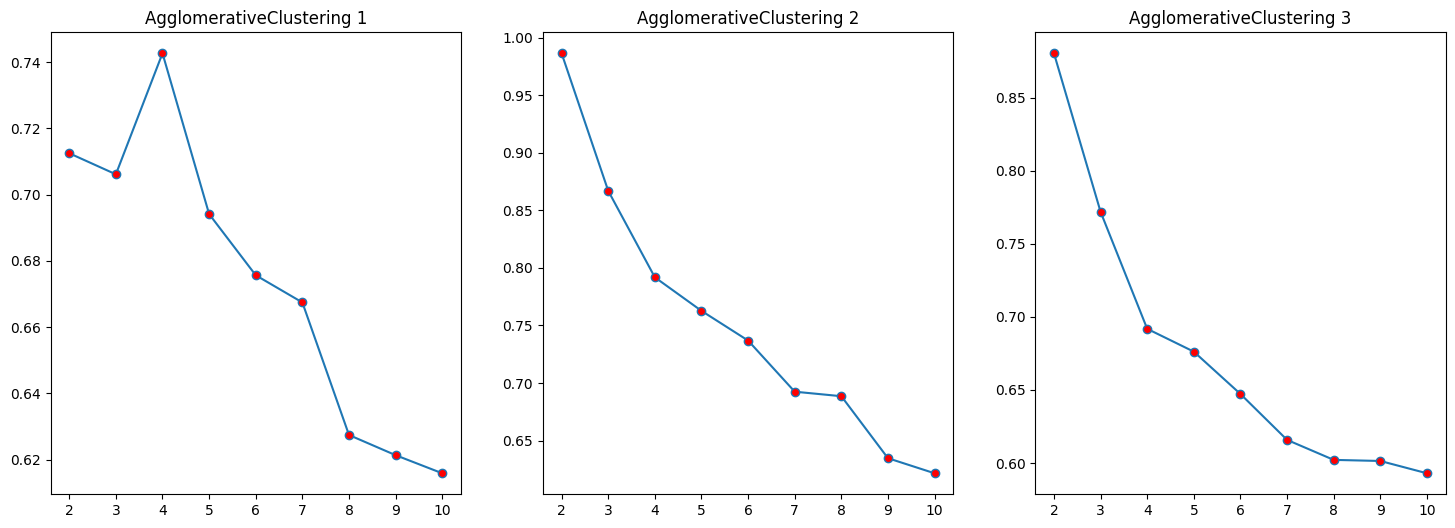

In [34]:
iterations = 10
plt.figure(figsize=(18, 6))
for index, data in enumerate([dict_rand['Model 1'], dict_rand['Model 2'], dict_rand['Model 3']]):
    plt.subplot(1, 3, index+1)
    plt.plot(range(2, iterations+1), data, marker='o', markerfacecolor=[1, 0, 0, 1])
    plt.title("AgglomerativeClustering {}".format(index+1))
plt.show()

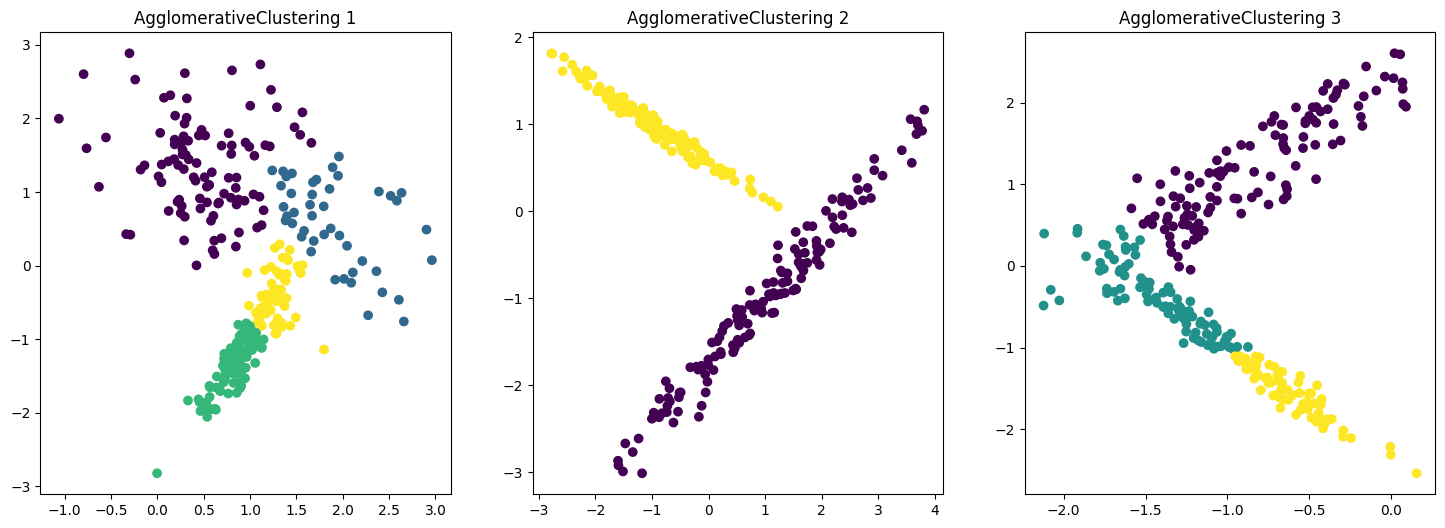

In [35]:
ac_model_one  = AgglomerativeClustering(4).fit(X_one)
ac_model_two  = AgglomerativeClustering(2).fit(X_two)
ac_model_three  = AgglomerativeClustering(3).fit(X_three)

plt.figure(figsize=(18, 6))
for index, (data, model) in enumerate([(X_one, ac_model_one), (X_two, ac_model_two), (X_three, ac_model_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.labels_)
    plt.title(f"AgglomerativeClustering {index+1}")
plt.show()

In [36]:
print_metrics("AgglomerativeClustering", ac_model_one, ac_model_two, ac_model_three)

{'AgglomerativeClustering 1': {'adjusted_rand_score': 0.48,
                               'calinski_harabasz_score': 391.38,
                               'rand_score': 0.74,
                               'silhouette_score': 0.43},
 'AgglomerativeClustering 2': {'adjusted_rand_score': 0.97,
                               'calinski_harabasz_score': 345.21,
                               'rand_score': 0.99,
                               'silhouette_score': 0.56},
 'AgglomerativeClustering 3': {'adjusted_rand_score': 0.54,
                               'calinski_harabasz_score': 504.64,
                               'rand_score': 0.77,
                               'silhouette_score': 0.48}}


## Hierarchy иерархическая  кластеризация

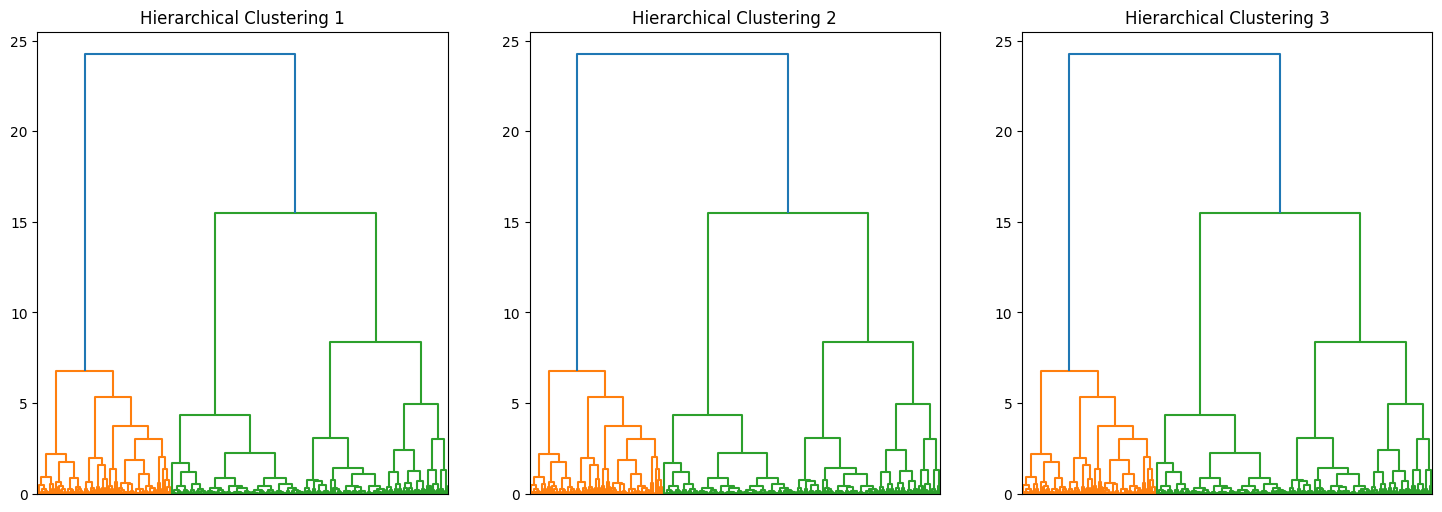

In [37]:
linkage_one = linkage(X_one, method='ward')
linkage_two = linkage(X_two, method='ward')
linkage_three = linkage(X_three, method='ward')

plt.figure(figsize=(18, 6))

for index, data in enumerate([linkage_one, linkage_two, linkage_three]):
    plt.subplot(1, 3, index+1)
    dendrogram(linkage_one)
    plt.title("Hierarchical Clustering {}".format(index+1))
    plt.gca().set_xticks([])
plt.show()

Сделать вывод

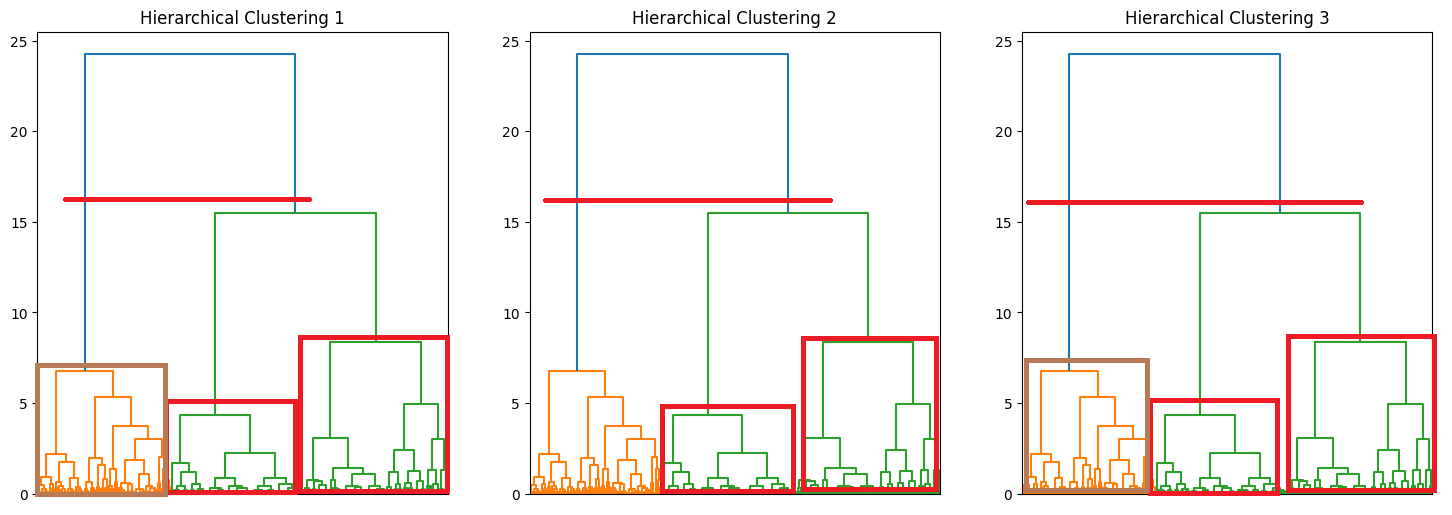

## Карты Кохонена

In [38]:
!pip install sklearn_som


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from sklearn_som.som import SOM

In [40]:
X_one.shape

(300, 2)

## Без подбора

In [41]:
som_one = SOM(m=2, n=1, dim=2)
som_one.fit(X_one)
som_two = SOM(m=2, n=1, dim=2)
som_two.fit(X_two)
som_three = SOM(m=2, n=1, dim=2)
som_three.fit(X_three)

In [42]:
print_metrics("SOM", som_one, som_two, som_three)

{'SOM 1': {'adjusted_rand_score': 0.7,
           'calinski_harabasz_score': 476.36,
           'rand_score': 0.85,
           'silhouette_score': 0.54},
 'SOM 2': {'adjusted_rand_score': 0.91,
           'calinski_harabasz_score': 369.21,
           'rand_score': 0.95,
           'silhouette_score': 0.57},
 'SOM 3': {'adjusted_rand_score': 0.72,
           'calinski_harabasz_score': 511.3,
           'rand_score': 0.86,
           'silhouette_score': 0.55}}


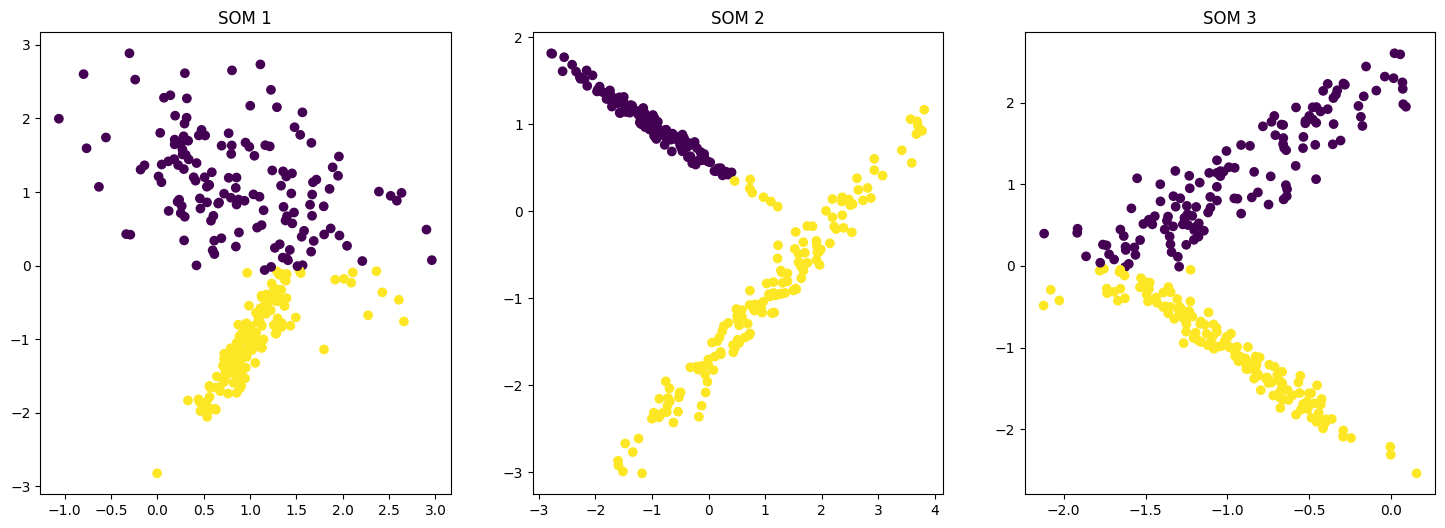

In [43]:
plt.figure(figsize=(18, 6))
for index, (data, model) in enumerate([(X_one, som_one), (X_two, som_two), (X_three, som_three)]):
    plt.subplot(1, 3, index+1)
    plt.scatter(data[:, 0], data[:, 1], c = model.predict(data))
    plt.title(f"SOM {index+1}")
plt.show()


Добавить визуализацию

## Подбор

In [44]:
n_iterations = 10
dict_rand = dict()

for index, (data, y) in enumerate([(X_one, y_one), (X_two, y_two), (X_three, y_three)]):
    scores = []
    best_rand_score = -np.inf

    for iter in range(2, n_iterations+1):
        model = SOM(m = iter, n=1, dim=2)
        model.fit(data)
        rand_score_value = rand_score(y, model.predict(data))
        scores.append(rand_score_value)
        if rand_score_value > best_rand_score:
            best_n_clusters = n_clusters

    dict_rand[f'Model {index+1}'] = scores

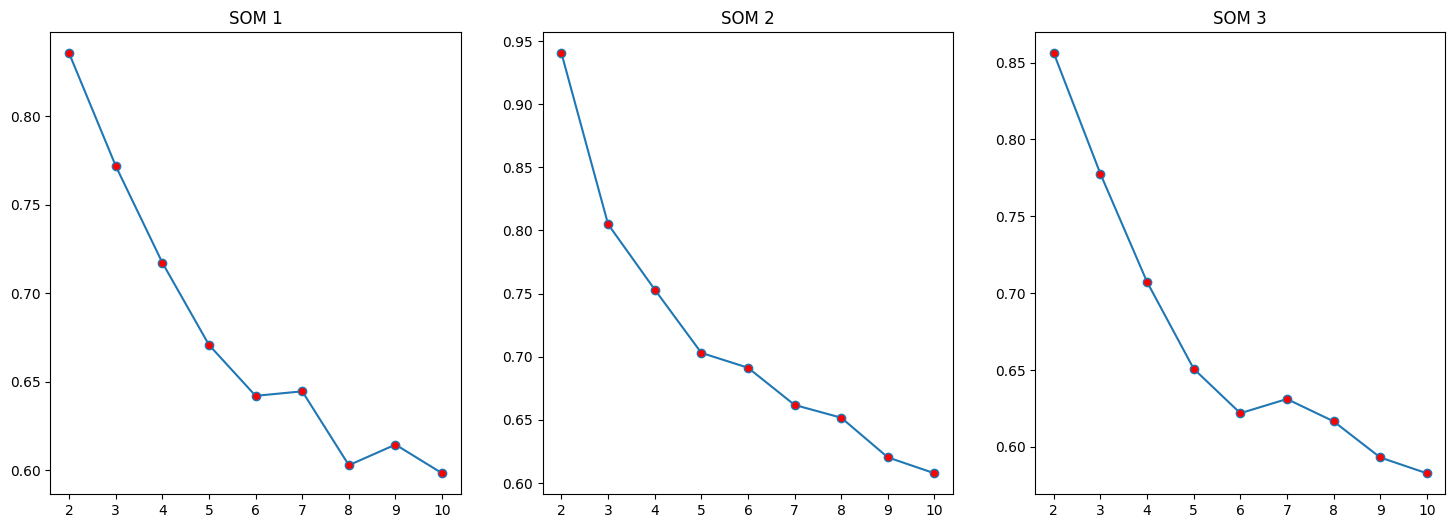

In [45]:
plt.figure(figsize=(18, 6))
for index, data in enumerate([dict_rand['Model 1'], dict_rand['Model 2'], dict_rand['Model 3']]):
    plt.subplot(1, 3, index+1)
    plt.plot(range(2, 11), data, marker='o', markerfacecolor=[1, 0, 0, 1])
    plt.title("SOM {}".format(index+1))
plt.show()

Результат идентичен предыдущему

# Задание 2

In [46]:
df= pd.read_csv('Data4.csv')
df.to_csv('Data4.csv')

In [47]:
df['id']=df['id'].map(lambda y: np.random.uniform(((df['id'].min()).round()), ((df['id'].max()).round()) if pd.isna(y) else y))
df['id']

0        2.223437e+06
1        3.731337e+06
2        2.540523e+06
3        3.277145e+06
4        2.484539e+06
             ...     
90831    6.072827e+06
90832    2.742985e+06
90833    2.601431e+06
90834    3.596642e+06
90835    3.133566e+06
Name: id, Length: 90836, dtype: float64

In [48]:
df.pop('name')

0          (2011 GZ2)
1          (2020 HT6)
2        (2016 ED156)
3          (2013 FD8)
4         (2016 CW31)
             ...     
90831       (2021 YE)
90832       (2018 KL)
90833    (2016 AB166)
90834    (2014 SQ260)
90835      (2012 EQ3)
Name: name, Length: 90836, dtype: object

In [49]:
df['est_diameter_max']=df['est_diameter_max'].map(lambda y: np.random.uniform(((df['est_diameter_max'].min()).round()), ((df['est_diameter_max'].max()).round()) if pd.isna(y) else y))
df['est_diameter_max']

0        0.000059
1        0.056469
2        0.076291
3        0.015378
4        0.184189
           ...   
90831    0.009892
90832    0.244950
90833    0.012860
90834    0.063754
90835    0.109448
Name: est_diameter_max, Length: 90836, dtype: float64

In [50]:
df['relative_velocity']=df['relative_velocity'].map(lambda y: np.random.uniform(((df['relative_velocity'].min()).round()), ((df['relative_velocity'].max()).round()) if pd.isna(y) else y))
df['relative_velocity']

0        48607.783245
1         4804.932198
2        16641.756412
3         9463.469229
4        52300.724061
             ...     
90831    19369.485312
90832    18292.153988
90833    93027.583407
90834     3671.518909
90835    48658.717692
Name: relative_velocity, Length: 90836, dtype: float64

In [51]:
df['absolute_magnitude']=df['absolute_magnitude'].map(lambda y: np.random.uniform(((df['absolute_magnitude'].min()).round()), ((df['absolute_magnitude'].max()).round()) if pd.isna(y) else y))
df['absolute_magnitude']

0        21.739939
1        15.395046
2        18.062618
3        10.906293
4        21.140524
           ...    
90831     9.651282
90832     9.166197
90833    10.229738
90834     9.136159
90835    18.961621
Name: absolute_magnitude, Length: 90836, dtype: float64

In [52]:
df.isna().sum()

Unnamed: 0.2          0
Unnamed: 0.1          0
Unnamed: 0            0
id                    0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [53]:
df.pop('Unnamed: 0.2')
df.pop('Unnamed: 0.1')
df.pop('Unnamed: 0')

0            0
1            1
2            2
3            3
4            4
         ...  
90831    90831
90832    90832
90833    90833
90834    90834
90835    90835
Name: Unnamed: 0, Length: 90836, dtype: int64

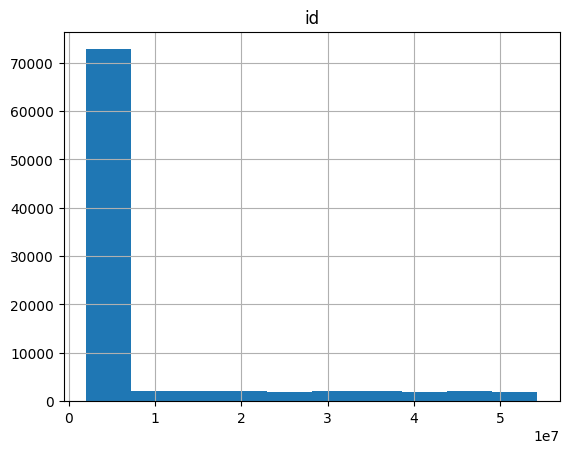

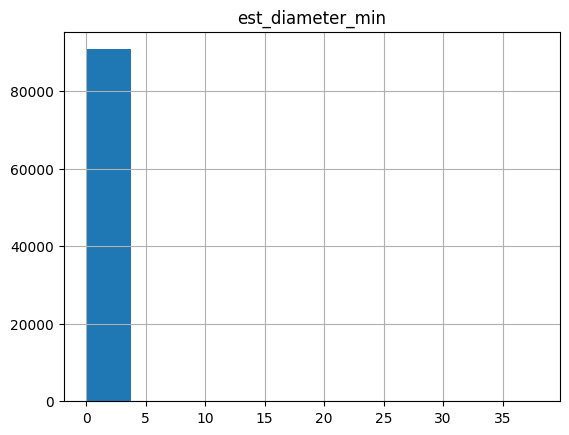

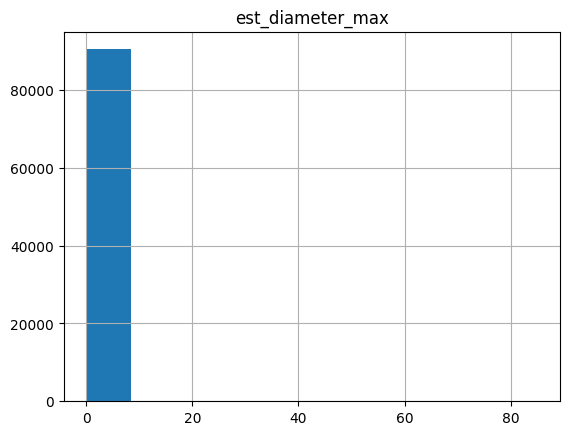

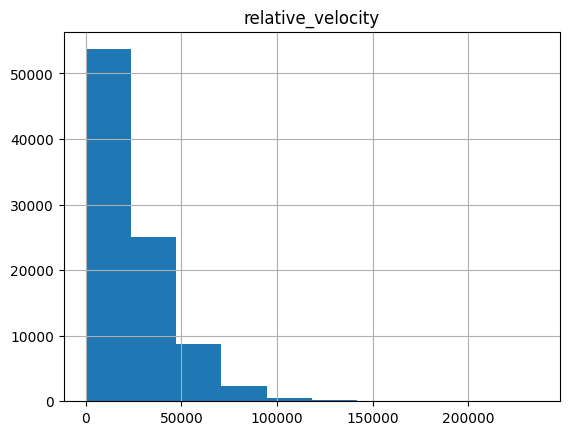

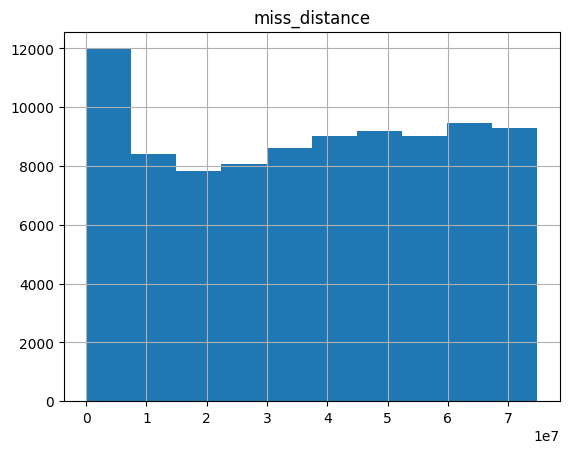

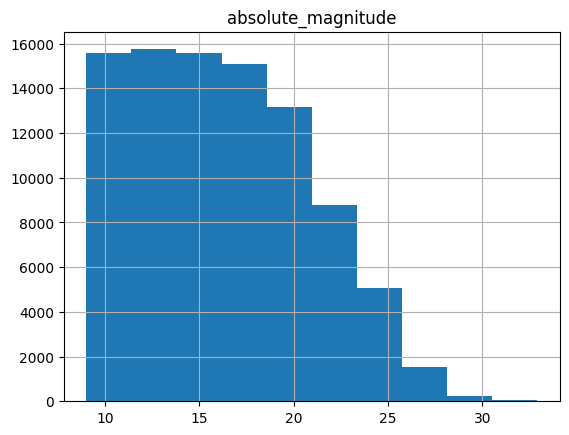

In [54]:
df.describe()[['id', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
columns = ['id', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']

for column in columns:
    df.hist(column)

In [55]:
outlier = df[['id', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]
outlier

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,2.223437e+06,0.016016,0.000059,48607.783245,1.024333e+06,21.739939
1,3.731337e+06,0.030518,0.056469,4804.932198,3.268186e+07,15.395046
2,2.540523e+06,0.055533,0.076291,16641.756412,6.538636e+07,18.062618
3,3.277145e+06,0.019256,0.015378,9463.469229,1.260796e+07,10.906293
4,2.484539e+06,0.139494,0.184189,52300.724061,7.130590e+07,21.140524
...,...,...,...,...,...,...
90831,6.072827e+06,0.017561,0.009892,19369.485312,1.635007e+06,9.651282
90832,2.742985e+06,0.110804,0.244950,18292.153988,3.351901e+07,9.166197
90833,2.601431e+06,0.035039,0.012860,93027.583407,5.471396e+07,10.229738
90834,3.596642e+06,0.044112,0.063754,3671.518909,2.694877e+07,9.136159


In [56]:
Q1 = outlier.quantile(0.25)
Q1

id                    2.337244e+06
est_diameter_min      1.925551e-02
est_diameter_max      1.518179e-02
relative_velocity     9.022870e+03
miss_distance         1.721082e+07
absolute_magnitude    1.248698e+01
Name: 0.25, dtype: float64

In [57]:
Q3 = outlier.quantile(0.75)
Q3

id                    3.623122e+06
est_diameter_min      1.434019e-01
est_diameter_max      1.430113e-01
relative_velocity     3.456451e+04
miss_distance         5.654900e+07
absolute_magnitude    1.960712e+01
Name: 0.75, dtype: float64

In [58]:
IQR = Q3-Q1
data_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,2.223437e+06,0.016016,0.000059,48607.783245,1.024333e+06,21.739939
1,3.731337e+06,0.030518,0.056469,4804.932198,3.268186e+07,15.395046
2,2.540523e+06,0.055533,0.076291,16641.756412,6.538636e+07,18.062618
3,3.277145e+06,0.019256,0.015378,9463.469229,1.260796e+07,10.906293
4,2.484539e+06,0.139494,0.184189,52300.724061,7.130590e+07,21.140524
...,...,...,...,...,...,...
90828,2.735117e+06,0.024241,0.011142,7160.740285,1.474121e+07,9.901335
90830,3.668379e+06,0.008405,0.017719,5271.884525,3.821292e+06,19.455289
90832,2.742985e+06,0.110804,0.244950,18292.153988,3.351901e+07,9.166197
90834,3.596642e+06,0.044112,0.063754,3671.518909,2.694877e+07,9.136159


In [59]:
index_list = list(data_filtered.index.values)
data_filtered = df[df.index.isin(index_list)]
data_filtered.head()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2.223437e+06,0.016016,0.000059,48607.783245,1.024333e+06,21.739939,False
1,3.731337e+06,0.030518,0.056469,4804.932198,3.268186e+07,15.395046,False
2,2.540523e+06,0.055533,0.076291,16641.756412,6.538636e+07,18.062618,False
3,3.277145e+06,0.019256,0.015378,9463.469229,1.260796e+07,10.906293,False
4,2.484539e+06,0.139494,0.184189,52300.724061,7.130590e+07,21.140524,False


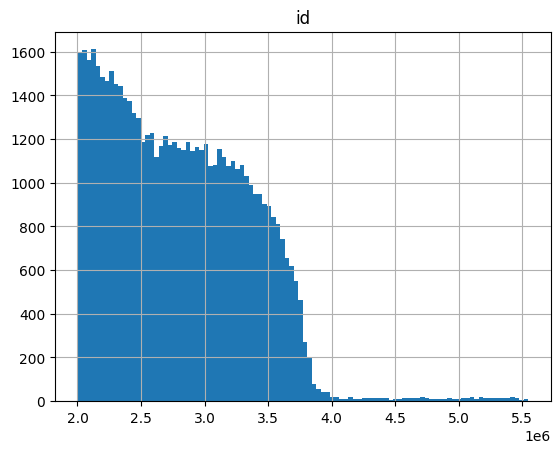

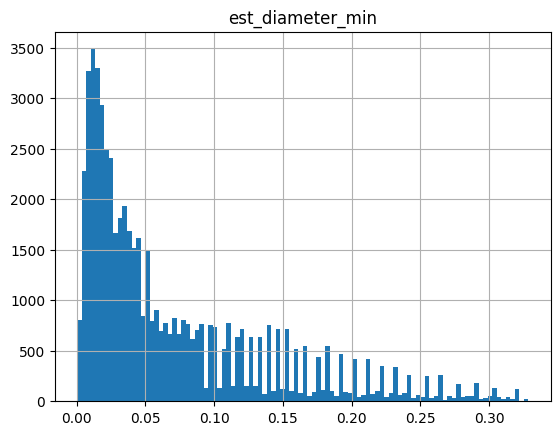

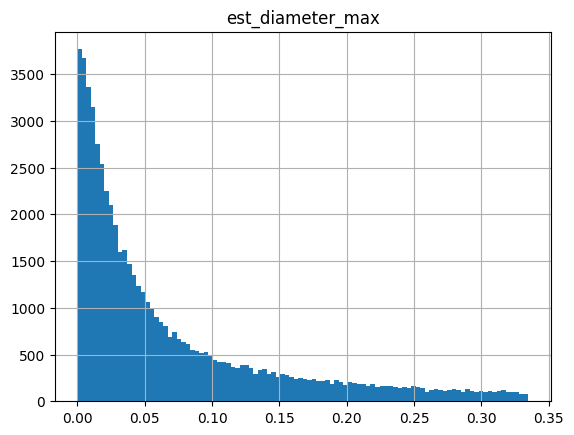

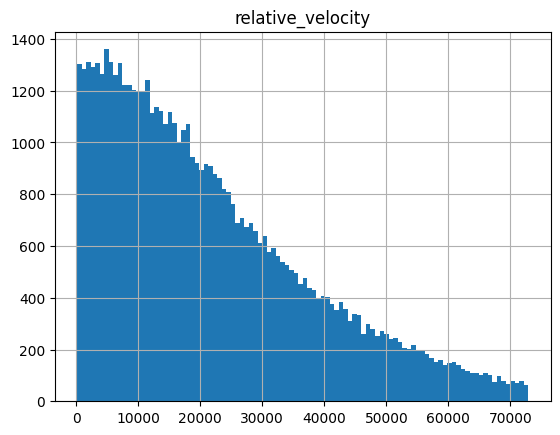

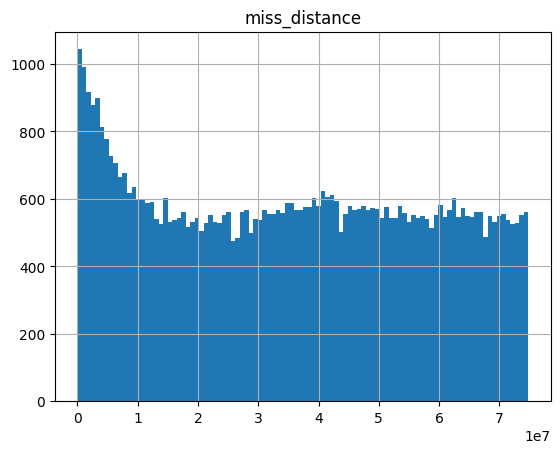

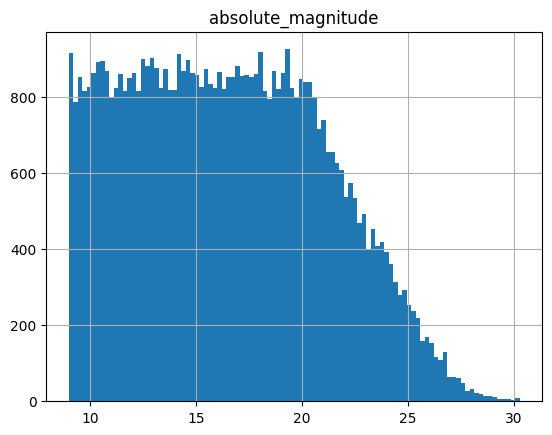

In [60]:
filtered_outlier = data_filtered[['id', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']]

for col in filtered_outlier:
    data_filtered.hist(col, bins=100)

In [62]:
data_filtered.loc[(data_filtered['hazardous'] == "True"), 'hazardous'] = 1
data_filtered.loc[(data_filtered['hazardous'] == "False"), 'hazardous'] = 0

D:\environment\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\environment\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


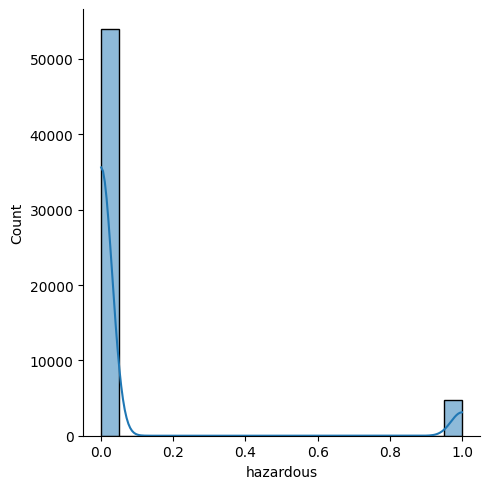

In [63]:
sns.displot(data_filtered["hazardous"],bins=20,kde=True);

## KMeans

In [64]:
kmeans = KMeans(n_init='auto').fit(X)

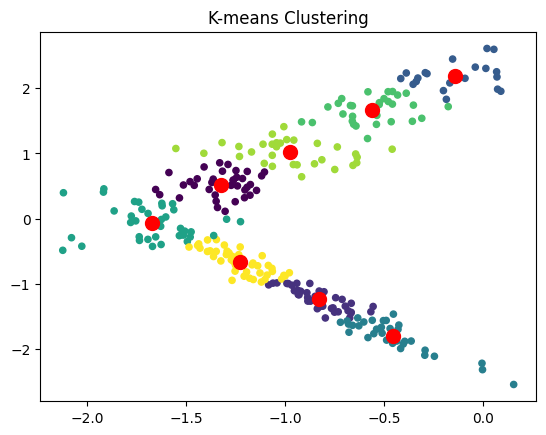

In [65]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='o', s=100)
plt.title('K-means Clustering')
plt.show()

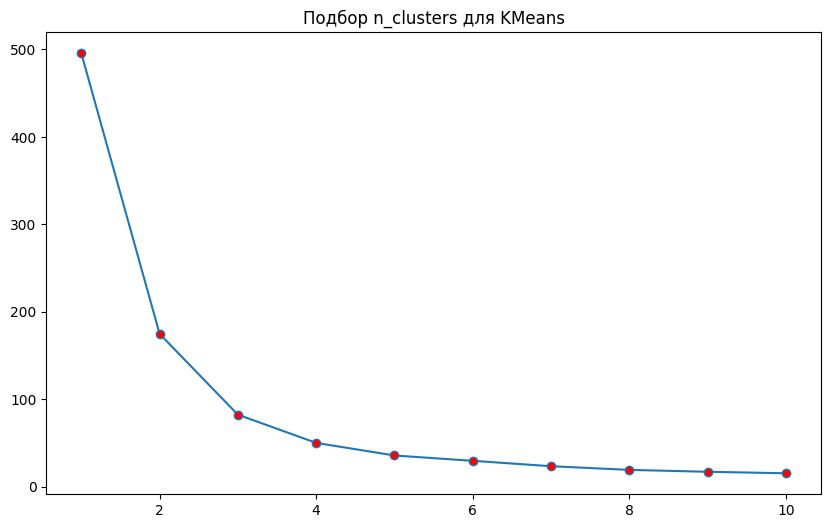

In [66]:
plt.figure(figsize=(10, 6))
scores = elbow_method(X, 10)
plt.plot(range(1, 11), scores, marker='o', markerfacecolor=[1, 0, 0, 1])
plt.title("Подбор n_clusters для KMeans")
plt.show()

In [67]:
kmeans = KMeans(n_clusters=2, n_init='auto').fit(X)

Сравнить результат с n = 3

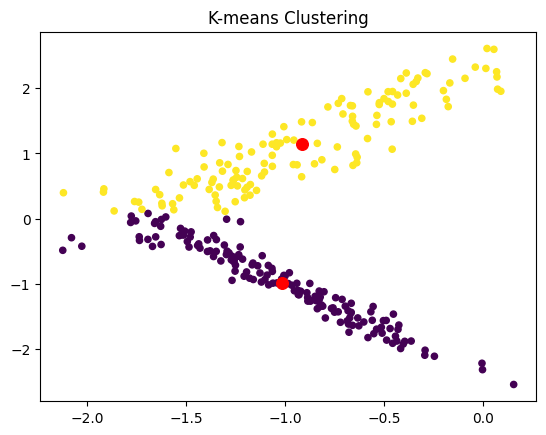

In [72]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=20)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='o', s=70)
plt.title('K-means Clustering')
plt.show()

## DBSCAN

In [73]:
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()
X_dbscan = scaler.fit_transform(X)

In [75]:
dbscan = DBSCAN().fit(X_dbscan)

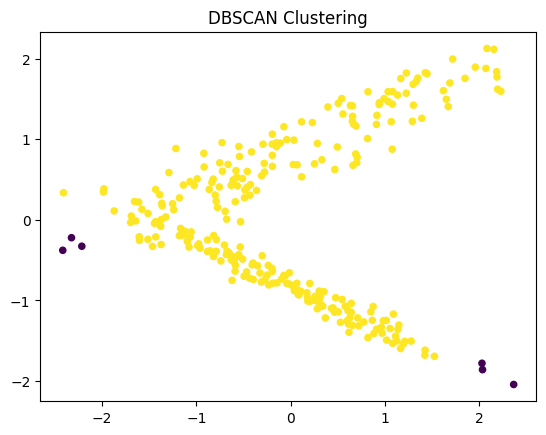

In [76]:
plt.scatter(X_dbscan[:, 0], X_dbscan[:, 1], c=dbscan.labels_, cmap='viridis', s=20)
plt.title('DBSCAN Clustering')
plt.show()

In [77]:
eps_values = [0.1, 0.3, 0.5, 1, 2, 3]
min_samples_values = [3, 4, 5, 6, 7]
best_score = -np.inf

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        rand = rand_score(y, dbscan.labels_)

        if rand > best_score:
            best_score = rand
            temporary_dict = {"eps": eps, 'min_samples': min_samples, 'best_rand': rand}

In [78]:
temporary_dict

{'eps': 0.1, 'min_samples': 4, 'best_rand': 0.7205473272686265}

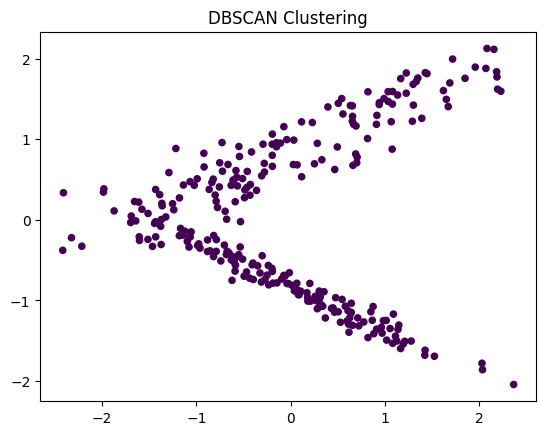

In [79]:
dbscan = DBSCAN(eps=1, min_samples=3).fit(X_dbscan)
plt.scatter(X_dbscan[:, 0], X_dbscan[:, 1], c=dbscan.labels_, cmap='viridis', s=20)
plt.title('DBSCAN Clustering')
plt.show()

In [ ]:
##print(f'silhouette_score: {round(silhouette_score(X_dbscan, dbscan.labels_),1)}')
##silhouette_score: 0.1

In [ ]:
##print(f'calinski_harabasz_score: {round(calinski_harabasz_score(X_dbscan, dbscan.labels_), 2)}')
##calinski_harabasz_score: 918.71

In [95]:
print(f'rand_score: {round(rand_score(dbscan.labels_, y), 2)}')
print(f'adjusted_rand_score: {round(adjusted_rand_score(y, dbscan.labels_), 2)}')

rand_score: 0.5
adjusted_rand_score: 0.0


## Иерархическая  кластеризация

In [83]:
X_hierarchical = X[:10000, :]
y_hierarchical = y[:10000]

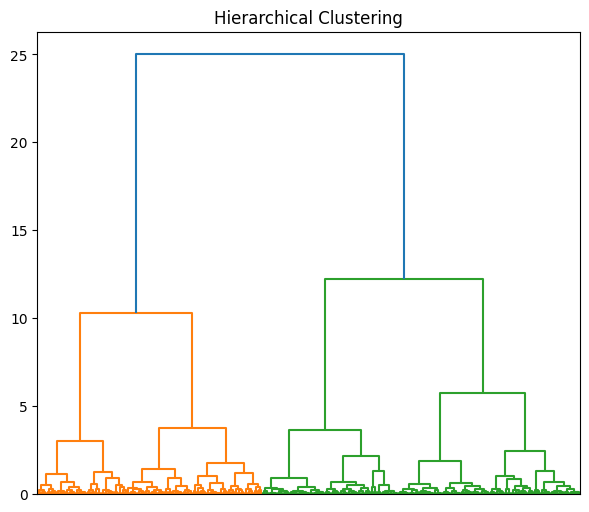

In [84]:
linkage_one = linkage(X_hierarchical, method='ward')
plt.figure(figsize=(7, 6))
dendrogram(linkage_one)
plt.title("Hierarchical Clustering")
plt.gca().set_xticks([])
plt.show()

Добавить вывод

In [85]:
num_clusters = 2
labels = fcluster(linkage_one, num_clusters, criterion='maxclust')
print(f'silhouette_score: {round(silhouette_score(X_hierarchical, labels), 2)}')
print(f'calinski_harabasz_score: {round(calinski_harabasz_score(X_hierarchical, labels), 2)}')
print(f'rand_score: {round(rand_score(y_hierarchical, labels), 2)}')
print(f'adjusted_rand_score: {round(adjusted_rand_score(y_hierarchical, labels), 2)}')

silhouette_score: 0.54
calinski_harabasz_score: 484.19
rand_score: 0.88
adjusted_rand_score: 0.76


# Реализация KMeans

In [86]:
class KMeans_:
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        self.centers = X[np.random.choice(len(X), self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2), axis=1)
            new_centers = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.all(self.centers == new_centers):
                break

            self.centers = new_centers

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centers, axis=2), axis=1)

In [87]:
kmeans_o = KMeans_()
kmeans_t = KMeans_()
kmeans_th = KMeans_()

In [88]:
kmeans_o.fit(X_one)
kmeans_t.fit(X_two)
kmeans_th.fit(X_three)

In [89]:
print_metrics("My KMeans", kmeans_o, kmeans_t, kmeans_th)

{'My KMeans 1': {'adjusted_rand_score': 0.74,
                 'calinski_harabasz_score': 493.35,
                 'rand_score': 0.87,
                 'silhouette_score': 0.55},
 'My KMeans 2': {'adjusted_rand_score': 0.89,
                 'calinski_harabasz_score': 369.26,
                 'rand_score': 0.95,
                 'silhouette_score': 0.57},
 'My KMeans 3': {'adjusted_rand_score': 0.74,
                 'calinski_harabasz_score': 516.6,
                 'rand_score': 0.87,
                 'silhouette_score': 0.56}}


## Silhouette Score (Коэффициент силуэта):

Значение коэффициента силуэта находится в пределах от -1 до 1. Большие значения указывают на хорошее разделение кластеров. Положительные значения означают, что объекты в кластерах более похожи друг на друга, чем на объекты в соседних кластерах. Отрицательные значения могут возникнуть, когда объекты в кластерах менее похожи друг на друга, чем на объекты в соседних кластерах.

## Calinski-Harabasz Score:

Этот показатель оценивает отношение между дисперсией внутри кластеров и дисперсией между кластерами. Большие значения указывают на более четкое разделение кластеров. Он рассчитывается как отношение межкластерной дисперсии к внутрикластерной дисперсии.


## Adjusted Rand Index (Корректированный индекс Ренда):

Этот индекс измеряет схожесть между исходной кластеризацией и предсказанной. Значение 0 указывает на случайное разделение, а 1 - на идентичное разделение. Отрицательные значения указывают на случайное разделение.

## Rand_score
Индекс Рэнда вычисляет меру сходства между двумя кластеризациями, рассматривая все пары выборок и подсчитывая пары, которые назначены в одни и те же или разные кластеры в предсказанных и истинных кластеризациях